In [22]:
# import libraries
import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = '15'

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, Ridge

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, Normalizer, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer
from scipy.stats import skew

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [2]:
# read the dataframe
data_path = Path.cwd().parent / 'data' / 'paris_solcast_cleaned.csv'
df = pd.read_csv(data_path, index_col=0)
df = df.drop(columns=['date'])    

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1087 entries, 0 to 1086
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    1087 non-null   float64
 1   CloudOpacity   1087 non-null   float64
 2   DHI            1087 non-null   float64
 3   DNI            1087 non-null   float64
 4   Radiation      1087 non-null   float64
 5   Precipitation  1087 non-null   float64
 6   Humidity       1087 non-null   float64
 7   Pressure       1087 non-null   float64
 8   WindDirection  1087 non-null   float64
 9   WindSpeed      1087 non-null   float64
 10  Sunrise        1087 non-null   int64  
 11  Sunset         1087 non-null   int64  
 12  Month          1087 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 118.9 KB


## Split the data

In [4]:
from sklearn.model_selection import train_test_split 
# stratify also along the month column
# check that the rain ratio per month is equal between train and test set
df_train, df_test = train_test_split(df, test_size=0.25, stratify=df[['Month']]) 

print("Size of train:", round(len(df_train)/len(df)*100, 2), "% of original dataframe")
print("Size of test:", round(len(df_test)/len(df)*100, 2), "% of original dataframe")


Size of train: 74.98 % of original dataframe
Size of test: 25.02 % of original dataframe


In [5]:
def get_features_and_label(df):
    label = np.ravel(np.array(df['Radiation']).T)
    features = df.drop(columns=['Radiation']).to_numpy()
    return features, label

In [6]:
#Split the data into X and y
X_train, y_train = get_features_and_label(df_train)
X_test, y_test = get_features_and_label(df_test)

In [7]:
X_train.shape, y_train.shape

((815, 12), (815,))

## Modeling

In [8]:
skewed_features = []
for col in df_train.columns.to_list()[:-2]:    
    if col != 'Radiation':
        if((min(df_train[col]) > 0)) & (abs(skew(df_train[col])) > 0):
            skewed_features.append(col)
        
skewed_features

['DHI', 'Precipitation', 'Humidity', 'Pressure', 'WindDirection', 'WindSpeed']

In [9]:
def log_transform(x):
    return np.log(x + 1)

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ("month_encoder", OneHotEncoder(handle_unknown="ignore"), ['Month']),
        ("log_transform", FunctionTransformer(log_transform), skewed_features)
    ],
    remainder='passthrough'
)

In [11]:
pipeline = Pipeline([  
    ('preprocessing', preprocessor),
    ('scaler' , StandardScaler()),
    ('model' , RandomForestRegressor())
])

In [12]:
parameters = {
    'preprocessing__month_encoder': ['passthrough', OneHotEncoder(handle_unknown='ignore')],
    'preprocessing__log_transform': ['passthrough', FunctionTransformer(log_transform)],
    'scaler': ['passthrough', StandardScaler(), MinMaxScaler(), Normalizer(), RobustScaler()],
    'model': [LinearRegression(), RandomForestRegressor(), Ridge()]
}

In [13]:
X_train = df_train.drop(columns=['Radiation'])
y_train = df_train['Radiation']

X_test = df_test.drop(columns=['Radiation'])
y_test = df_test['Radiation']

In [14]:
X_train

,Temperature,CloudOpacity,DHI,DNI,Precipitation,Humidity,Pressure,WindDirection,WindSpeed,Sunrise,Sunset,Month
302,9.736364,47.600000,123.818182,22.909091,19.909091,63.163636,1011.090909,73.727273,4.109091,9,18,10
909,18.462500,58.675000,184.062500,42.000000,32.156250,85.168750,1002.768750,149.625000,1.443750,9,22,6
28,3.750000,25.630000,80.100000,222.700000,7.470000,70.840000,990.600000,309.400000,6.190000,9,18,1
859,16.073333,40.933333,219.266667,164.266667,20.286667,63.660000,1001.426667,198.133333,4.853333,9,21,5
720,9.425000,24.075000,76.625000,212.375000,12.400000,78.025000,1008.387500,213.625000,3.600000,0,17,12
...,...,...,...,...,...,...,...,...,...,...,...,...
652,11.418182,49.636364,138.181818,39.454545,17.836364,73.754545,998.309091,256.909091,3.563636,9,19,10
618,23.342857,12.921429,101.571429,478.428571,31.921429,54.792857,1012.907143,301.642857,2.435714,9,21,9
612,22.171429,25.278571,187.285714,225.000000,31.814286,42.964286,1010.750000,231.857143,3.128571,9,21,9
862,13.418750,47.181250,193.187500,52.375000,16.850000,65.712500,999.781250,231.937500,3.387500,9,22,5


In [15]:
scoring = {'max_error': 'max_error', 'neg_mean_squared_error': 'neg_mean_squared_error', 'r2':'r2'}

grid = GridSearchCV(pipeline, parameters, cv=5, scoring=scoring, refit='r2', return_train_score=True).fit(X_train, y_train)

print('Training set score: ' + str(grid.score(X_train, y_train)))
print('Test set score: ' + str(grid.score(X_test, y_test)))
 
# Access the best set of parameters
best_params = grid.best_params_
#print(best_params)
# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print(best_pipe)

Training set score: 0.9972211189581687
Test set score: 0.9851791894931958
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('month_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Month']),
                                                 ('log_transform',
                                                  'passthrough',
                                                  ['DHI', 'Precipitation',
                                                   'Humidity', 'Pressure',
                                                   'WindDirection',
                                                   'WindSpeed'])])),
                ('scaler', MinMaxScaler()),
                ('model', RandomForestRegressor())])


## Plotting the predictions

In [20]:
y_pred = best_pipe.predict(X_test)

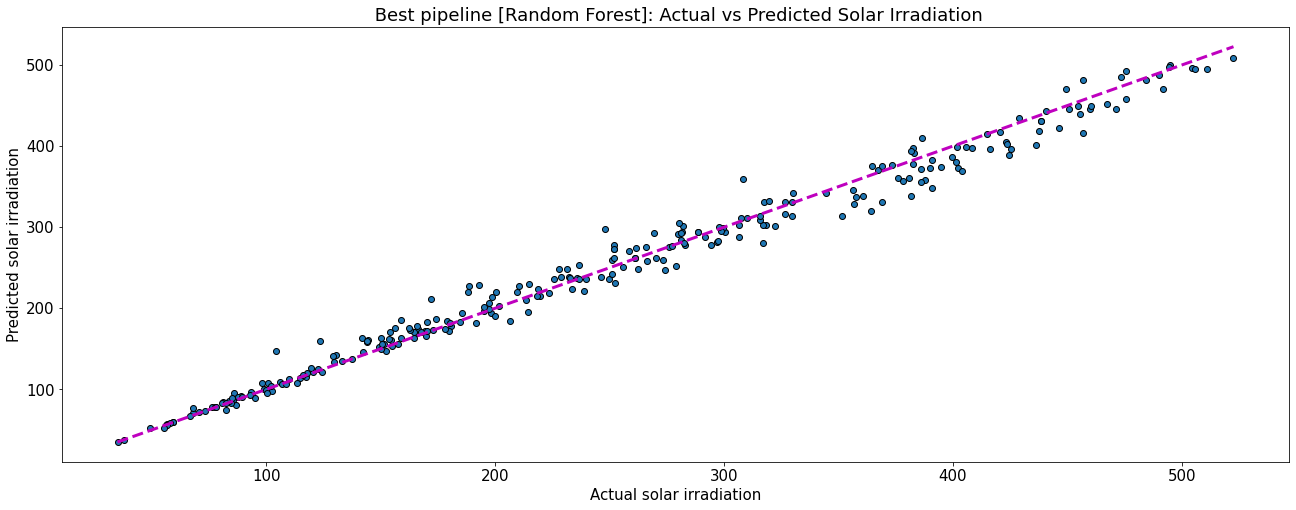

In [31]:
# run the model against the test data presented through a plot
fig, ax = plt.subplots(figsize=(22,8))

ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'm--', lw=3)
ax.set_xlabel('Actual solar irradiation')
ax.set_ylabel('Predicted solar irradiation')
ax.set_title(" Best pipeline [Random Forest]: Actual vs Predicted Solar Irradiation");

C:\Users\maxlu\Anaconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


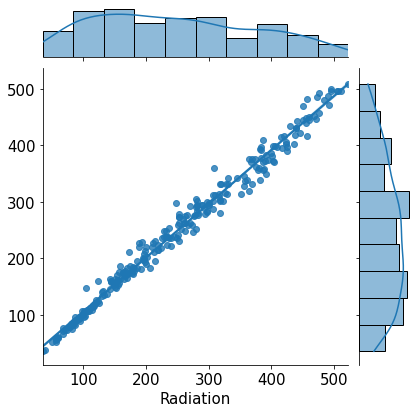

In [38]:
sns.jointplot(y_test, y_pred, kind='reg', ax=ax)
plt.show()